In [2]:
import pickle
import behavior.boris_extraction as boris
import spike.spike_analysis.spike_collection as sc
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy.stats import sem
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel
import matplotlib.patches as mpatches
from itertools import combinations
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

def hex_2_rgb(hex_color): # Orange color
    rgb_color = tuple(int(hex_color[i:i+2], 16) / 255.0 for i in (1, 3, 5))
    return rgb_color

def pickle_this(thing_to_pickle, file_name):
    """
    Pickles things
    Args (2):   
        thing_to_pickle: anything you want to pickle
        file_name: str, filename that ends with .pkl 
    Returns:
        none
    """
    with open(file_name,'wb') as file:
        pickle.dump(thing_to_pickle, file)

def unpickle_this(pickle_file):
    """
    Unpickles things
    Args (1):   
        file_name: str, pickle filename that already exists and ends with .pkl
    Returns:
        pickled item
    """
    with open(pickle_file, 'rb') as file:
        return(pickle.load(file))


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.6 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "c:\Users\megha\anaconda3\envs\ephys_env\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "c:\Users\megha\anaconda3\envs\ephys_env\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "c:\Users\megha\anaconda3\envs\ephys_env\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
 

AttributeError: _ARRAY_API not found

# Load collection and create behavior dataframe 

In [3]:
only_subject_collection = sc.SpikeCollection.load_collection(r'pilot2/only_subjects/only_subjects_spike_collection/spike_collection.json')
event_info = {}
is_first = True
sniff_itis = []
total_sniffs = 0
for recording in only_subject_collection.recordings:
    for event, events in recording.event_dict.items():
        no_events = events.shape[0]
        sniff_length = 0
        for i in range(len(events)):
            if (event == 'acquisition') and is_first: 
                first_five_min = events[i][0] + 300000
                is_first = False
            if (event == 'acquisition') | (event == 'exposure 0'):
               if events[i][0] < first_five_min:
                   sniff_length_temp = events[i][1] - events[i][0]
                   sniff_length = sniff_length +sniff_length_temp
                   total_sniffs = total_sniffs + 1
               else:
                   pass
            else:
                sniff_length_temp = events[i][1] - events[i][0]
                sniff_length = sniff_length +sniff_length_temp
                total_sniffs = total_sniffs + 1
            try:
                sniff_iti = events[i+1][0] - events[i][1]
                sniff_itis.append(sniff_iti)
            except IndexError:
                pass
        total_sniff_time = sniff_length/1000
        avg_event = sniff_length/no_events/1000
        if (recording.name + recording.subject) in event_info.keys():
            dict_event = event_info[recording.name + recording.subject]
            dict_event[event] =  {'no_events': no_events, 'avg event': avg_event, 'total time': total_sniff_time}
            event_info[recording.name + recording.subject] =  dict_event
        else:
            event_info[recording.name + recording.subject] = {event: {'no_events': no_events, 'avg event': avg_event,'total time': total_sniff_time }}
        
event_info_df = pd.DataFrame.from_dict(event_info)
sniff_itis = np.array(sniff_itis)/1000
sniff_itis 
overlapping_sniffs = 0 
for i in range(len(sniff_itis)):
    if sniff_itis[i] < 4:
        overlapping_sniffs = overlapping_sniffs + 1
print(overlapping_sniffs) # 212 with 5 and 106 with 2 out of 532
print(total_sniffs) #after fixing 0 for 2 out of 424, and 107 for less than 5



542
2217


In [4]:
event_overview = pd.concat({k: pd.DataFrame(v) for k, v in event_info.items()}, axis=0)
event_overview = event_overview.reset_index()
event_overview


,level_0,level_1,baseline,cagemate,exposure 1,exposure 2,exposure 3,familiar,novel
0,11_CNF_merged.rec1.1,no_events,15.0,48.000000,48.000000,38.000000,39.000000,39.000000,38.000000
1,11_CNF_merged.rec1.1,avg event,2.5,2.065847,2.065847,3.468418,3.995510,3.995510,3.468418
2,11_CNF_merged.rec1.1,total time,37.5,99.160650,99.160650,131.799900,155.824900,155.824900,131.799900
3,11_NCF_merged.rec1.1,no_events,15.0,13.000000,25.000000,13.000000,32.000000,32.000000,25.000000
4,11_NCF_merged.rec1.1,avg event,2.5,1.211127,1.719094,1.211127,1.474645,1.474645,1.719094
5,11_NCF_merged.rec1.1,total time,37.5,15.744650,42.977350,15.744650,47.188650,47.188650,42.977350
6,12_CNF_merged.rec1.2,no_events,15.0,41.000000,41.000000,23.000000,20.000000,20.000000,23.000000
7,12_CNF_merged.rec1.2,avg event,2.5,2.115424,2.115424,2.115872,1.593757,1.593757,2.115872
8,12_CNF_merged.rec1.2,total time,37.5,86.732400,86.732400,48.665050,31.875150,31.875150,48.665050
9,13_NCF_merged.rec1.3,no_events,15.0,18.000000,29.000000,18.000000,9.000000,9.000000,29.000000


In [5]:


event_overview['order'] = event_overview['level_0'].apply(lambda x: x.split('_')[1])
event_overview['subject'] = event_overview['level_0'].astype(str).apply(lambda x: x.split('_')[0])
no_events = event_overview[event_overview['level_1'] == 'no_events']
FCN_df = event_overview[event_overview['order'] == 'FCN']
CNF_df = event_overview[event_overview['order'] == 'CNF']
NFC_df = event_overview[event_overview['order'] == 'NFC']
event_total_time = event_overview[event_overview['level_1'] == 'total time']
event_total_time_averages = {}
avg_events = []
sem_events = []
for event in ['familiar', 'novel', 'cagemate']:
    avg_event = event_total_time[event].mean()
    sem_event = sem(event_total_time[event])
    event_total_time_averages[event] = [avg_event, sem_event]
    avg_events.append(avg_event)
    sem_events.append(sem_event)
avg_events = np.array(avg_events)
sem_events = np.array(sem_events)
event_total_time_averages

{'familiar': [np.float64(50.750853333333666), np.float64(12.216769799497646)],
 'novel': [np.float64(69.96913666666701), np.float64(12.31413832933366)],
 'cagemate': [np.float64(52.946976666666664), np.float64(15.284184324561991)]}

In [6]:
event_overview

,level_0,level_1,baseline,cagemate,exposure 1,exposure 2,exposure 3,familiar,novel,order,subject
0,11_CNF_merged.rec1.1,no_events,15.0,48.000000,48.000000,38.000000,39.000000,39.000000,38.000000,CNF,11
1,11_CNF_merged.rec1.1,avg event,2.5,2.065847,2.065847,3.468418,3.995510,3.995510,3.468418,CNF,11
2,11_CNF_merged.rec1.1,total time,37.5,99.160650,99.160650,131.799900,155.824900,155.824900,131.799900,CNF,11
3,11_NCF_merged.rec1.1,no_events,15.0,13.000000,25.000000,13.000000,32.000000,32.000000,25.000000,NCF,11
4,11_NCF_merged.rec1.1,avg event,2.5,1.211127,1.719094,1.211127,1.474645,1.474645,1.719094,NCF,11
5,11_NCF_merged.rec1.1,total time,37.5,15.744650,42.977350,15.744650,47.188650,47.188650,42.977350,NCF,11
6,12_CNF_merged.rec1.2,no_events,15.0,41.000000,41.000000,23.000000,20.000000,20.000000,23.000000,CNF,12
7,12_CNF_merged.rec1.2,avg event,2.5,2.115424,2.115424,2.115872,1.593757,1.593757,2.115872,CNF,12
8,12_CNF_merged.rec1.2,total time,37.5,86.732400,86.732400,48.665050,31.875150,31.875150,48.665050,CNF,12
9,13_NCF_merged.rec1.3,no_events,15.0,18.000000,29.000000,18.000000,9.000000,9.000000,29.000000,NCF,13


In [7]:
subject_means = event_overview.groupby(['level_1', 'subject'])[['cagemate', 'familiar', 'novel']].mean()

# Step 2: Average across subjects for each level_1 category  
final_result = subject_means.groupby('level_1')[['cagemate', 'familiar', 'novel']].mean()
final_sem = subject_means.groupby('level_1')[['cagemate', 'familiar', 'novel']].sem()

final_result
final_sem

,cagemate,familiar,novel
level_1,,,
avg event,0.692411,0.208482,0.209730
no_events,3.805843,3.844946,3.183508
total time,13.789706,12.355511,11.579267


# Stats

In [8]:
event_total_time= event_total_time[['familiar', 'cagemate', 'novel']]
results = {}
p_values = pd.DataFrame(index=event_total_time.columns, columns=event_total_time.columns)
p_value_list = []
for pair in combinations(event_total_time.columns, 2):
    t_stat, p_value = ttest_rel(event_total_time[pair[0]],event_total_time[pair[1]])
    results[pair] = [t_stat, p_value]
    p_value_list.append(p_value)
            
results


{('familiar', 'cagemate'): [np.float64(-0.15070205508158105),
  np.float64(0.8823605637218115)],
 ('familiar', 'novel'): [np.float64(-1.5164173522160997),
  np.float64(0.15166511237186692)],
 ('cagemate', 'novel'): [np.float64(-1.1533257872204652),
  np.float64(0.2680877573890307)]}

In [9]:
adjusted_p_values = multipletests(p_value_list, method='holm')
adjusted_p_values

(array([False, False, False]),
 array([0.88236056, 0.45499534, 0.53617551]),
 np.float64(0.016952427508441503),
 0.016666666666666666)

# Plotting

In [10]:
event_total_time_averages

{'familiar': [np.float64(50.750853333333666), np.float64(12.216769799497646)],
 'novel': [np.float64(69.96913666666701), np.float64(12.31413832933366)],
 'cagemate': [np.float64(52.946976666666664), np.float64(15.284184324561991)]}

In [11]:
subject_means = event_overview.groupby(['level_1', 'subject'])[['cagemate', 'familiar', 'novel']].mean()

# Step 2: Average across subjects for each level_1 category  
final_result = subject_means.groupby('level_1')[['cagemate', 'familiar', 'novel']].mean()
final_sem = subject_means.groupby('level_1')[['cagemate', 'familiar', 'novel']].sem()

final_result
final_sem

,cagemate,familiar,novel
level_1,,,
avg event,0.692411,0.208482,0.209730
no_events,3.805843,3.844946,3.183508
total time,13.789706,12.355511,11.579267


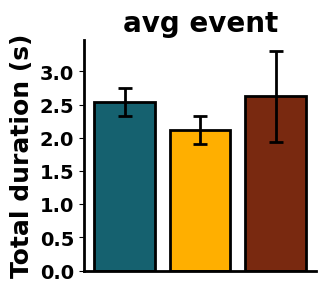

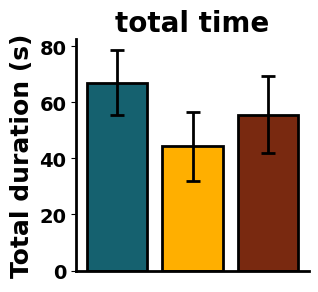

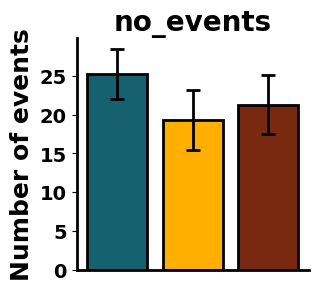

In [24]:
plt.rcParams['font.weight'] = 'bold'  # Set font weight to bold (not bold)
plt.rcParams['axes.titleweight'] = 'bold'  # Set axis title font weight to bold
plt.rcParams['axes.labelweight'] = 'bold'  # Set axis label font weight to bold

color_id_dict = {'novel': hex_2_rgb('#15616F'),  
                'short-term familiar\n(exposure 2)': (1.0, 0.6862745098039216, 0.0),
                'long-term familiar': hex_2_rgb('#792910')
                }
hatches = ['','','']  
edges = ['black', 'black', 'black']
avg_events = []
sem_events = []
for metric in ['avg event', 'total time', 'no_events']:
    avg_events = final_result.loc[metric].values
    sem_events = final_sem.loc[metric].values
    avg_events = avg_events[np.array([2,1,0])]
    sem_events = sem_events[np.array([2,1,0])]
    plt.figure(figsize= (3,3))      
    plt.bar(color_id_dict.keys(), avg_events, yerr = sem_events,
                color = color_id_dict.values(), hatch = hatches,
                edgecolor = edges, linewidth = 2,
                capsize = 5, error_kw={'elinewidth': 2, 'capthick': 2})
    plt.xticks([],rotation=45)
    if metric != 'no_events':
        plt.ylabel('Total duration (s)', fontsize = 18)
    else:
        plt.ylabel('Number of events', fontsize = 18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
    plt.gca().spines['left'].set_linewidth(2) 
    plt.title(f'{metric}', fontsize = 20)
    plt.show()


# Order of exposure EDA

In [25]:
subject_means_order = event_overview.groupby(['level_1', 'subject'])[['exposure 1', 'exposure 2', 'exposure 3']].mean()

# Step 2: Average across subjects for each level_1 category  
final_result_order = subject_means_order.groupby('level_1')[['exposure 1', 'exposure 2', 'exposure 3']].mean()
final_sem_order = subject_means_order.groupby('level_1')[['exposure 1', 'exposure 2', 'exposure 3']].sem()

final_result_order
final_sem_order

,exposure 1,exposure 2,exposure 3
level_1,,,
avg event,0.224219,0.159040,0.707352
no_events,2.769677,3.341823,3.431067
total time,9.269786,9.462683,16.845115


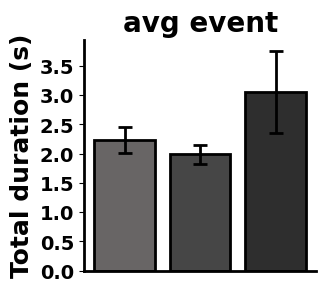

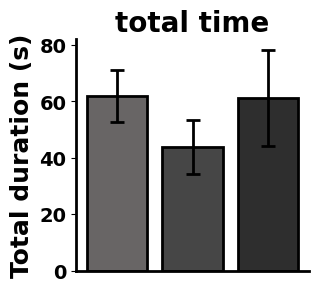

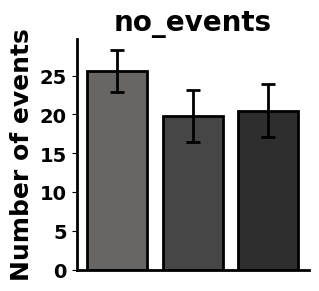

In [27]:
plt.rcParams['font.weight'] = 'bold'  # Set font weight to bold (not bold)
plt.rcParams['axes.titleweight'] = 'bold'  # Set axis title font weight to bold
plt.rcParams['axes.labelweight'] = 'bold'  # Set axis label font weight to bold

color_id_dict = {'exposure 1': "#686565",  
                'exposure 2': "#464646",
                'exposure 3': "#2E2E2E"
                }
hatches = ['','','']  
edges = ['black', 'black', 'black']
avg_events = []
sem_events = []
for metric in ['avg event', 'total time', 'no_events']:
    avg_events = final_result_order.loc[metric].values
    sem_events = final_sem_order.loc[metric].values
    plt.figure(figsize= (3,3))      
    plt.bar(color_id_dict.keys(), avg_events, yerr = sem_events,
                color = color_id_dict.values(), hatch = hatches,
                edgecolor = edges, linewidth = 2,
                capsize = 5, error_kw={'elinewidth': 2, 'capthick': 2})
    plt.xticks([],rotation=45)
    if metric != 'no_events':
        plt.ylabel('Total duration (s)', fontsize = 18)
    else:
        plt.ylabel('Number of events', fontsize = 18)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.gca().spines['bottom'].set_linewidth(2)  # X-axis
    plt.gca().spines['left'].set_linewidth(2) 
    plt.title(f'{metric}', fontsize = 20)
    plt.show()


# GLM STATS

In [29]:
event_overview

,level_0,level_1,baseline,cagemate,exposure 1,exposure 2,exposure 3,familiar,novel,order,subject
0,11_CNF_merged.rec1.1,no_events,15.0,48.000000,48.000000,38.000000,39.000000,39.000000,38.000000,CNF,11
1,11_CNF_merged.rec1.1,avg event,2.5,2.065847,2.065847,3.468418,3.995510,3.995510,3.468418,CNF,11
2,11_CNF_merged.rec1.1,total time,37.5,99.160650,99.160650,131.799900,155.824900,155.824900,131.799900,CNF,11
3,11_NCF_merged.rec1.1,no_events,15.0,13.000000,25.000000,13.000000,32.000000,32.000000,25.000000,NCF,11
4,11_NCF_merged.rec1.1,avg event,2.5,1.211127,1.719094,1.211127,1.474645,1.474645,1.719094,NCF,11
5,11_NCF_merged.rec1.1,total time,37.5,15.744650,42.977350,15.744650,47.188650,47.188650,42.977350,NCF,11
6,12_CNF_merged.rec1.2,no_events,15.0,41.000000,41.000000,23.000000,20.000000,20.000000,23.000000,CNF,12
7,12_CNF_merged.rec1.2,avg event,2.5,2.115424,2.115424,2.115872,1.593757,1.593757,2.115872,CNF,12
8,12_CNF_merged.rec1.2,total time,37.5,86.732400,86.732400,48.665050,31.875150,31.875150,48.665050,CNF,12
9,13_NCF_merged.rec1.3,no_events,15.0,18.000000,29.000000,18.000000,9.000000,9.000000,29.000000,NCF,13


In [49]:
def get_exposure_number(condition, order):
    # Create mapping from condition to letter
    condition_to_letter = {
        'familiar': 'F',
        'cagemate': 'C', 
        'novel': 'N'
    }
    
    # Find the position of the condition's letter in the order string
    letter = condition_to_letter[condition]
    position = order.index(letter) + 1  # +1 because we want 1-based indexing
    
    return position

df_long = event_overview.melt(id_vars=['level_0', 'subject', 'level_1', 'order'], 
                       value_vars=['cagemate', 'familiar', 'novel'],
                       var_name='condition', 
                       value_name='score')
df_long

df_long['exposure_number'] = df_long.apply(lambda row: get_exposure_number(row['condition'], row['order']), axis=1)
df_long
df_long.to_csv('pilot2/only_subjects/only_subjects_behavior_data.csv', index=False)

In [ ]:
total_time = event_overview[['level_1'] == 'total time']  
total_time

,level_0,level_1,baseline,cagemate,exposure 1,exposure 2,exposure 3,familiar,novel,order,subject
2,11_CNF_merged.rec1.1,total time,37.5,99.16065,99.16065,131.79990,155.82490,155.82490,131.79990,CNF,11
5,11_NCF_merged.rec1.1,total time,37.5,15.74465,42.97735,15.74465,47.18865,47.18865,42.97735,NCF,11
8,12_CNF_merged.rec1.2,total time,37.5,86.73240,86.73240,48.66505,31.87515,31.87515,48.66505,CNF,12
11,13_NCF_merged.rec1.3,total time,37.5,23.49045,56.60035,23.49045,28.25815,28.25815,56.60035,NCF,13
14,21_FCN_merged.rec2.1,total time,37.5,44.07495,28.96465,44.07495,36.93340,28.96465,36.93340,FCN,21
17,21_NCF_merged.rec2.1,total time,37.5,34.09250,62.00950,34.09250,7.56365,7.56365,62.00950,NCF,21
20,22_FCN_merged.rec2.2,total time,37.5,3.94970,17.98005,3.94970,16.12305,17.98005,16.12305,FCN,22
23,22_NCF_merged.rec2.2,total time,37.5,9.28535,29.90020,9.28535,27.25370,27.25370,29.90020,NCF,22
26,23_CNF_merged.rec2.3,total time,37.5,17.92370,17.92370,43.43690,114.53300,114.53300,43.43690,CNF,23
29,23_NFC_merged.rec2.3,total time,37.5,218.84255,120.11825,138.02300,218.84255,138.02300,120.11825,NFC,23
